<a href="https://colab.research.google.com/github/anjalii-s/Big_Data_Ethereum_Fraud_Detection/blob/main/Ethereum_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ethereum Fraud Detection Using Big Data analytics and Machine Learning


Dataset source :https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset?referrer=grok.com



The following cell installs all required Python libraries used throughout the Big Data processing, machine learning modelling, and explainability stages of the project.

In [1]:
!pip install pyspark shap imbalanced-learn xgboost -q -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 4.1.0 which is incompatible.



 IMPORT REQUIRED LIBRARIES


In [2]:


import pandas as pd
import numpy as np

# PySpark (Big Data processing)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Spark ML
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluation & visualisation
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability
import shap


Spark ML allows distributed model training, even if dataset is moderate-sized.


START SPARK SESSION


In [3]:


spark = SparkSession.builder \
    .appName("Ethereum_Fraud_Detection_BigData") \
    .getOrCreate()


Spark abstracts cluster computing which is scalable to millions of transactions.

LOAD DATA USING SPARK-
Load the Ethereum transaction dataset into a Spark DataFrame with automatic schema inference (Spark detects column data types automatically)

In [4]:


df = spark.read.csv(
    "transaction_dataset.csv",
    header=True,
    inferSchema=True
)

df.printSchema()
df.show(5)


root
 |-- _c0: integer (nullable = true)
 |-- Index: integer (nullable = true)
 |-- Address: string (nullable = true)
 |-- FLAG: integer (nullable = true)
 |-- Avg min between sent tnx: double (nullable = true)
 |-- Avg min between received tnx: double (nullable = true)
 |-- Time Diff between first and last (Mins): double (nullable = true)
 |-- Sent tnx: integer (nullable = true)
 |-- Received Tnx: integer (nullable = true)
 |-- Number of Created Contracts: integer (nullable = true)
 |-- Unique Received From Addresses: integer (nullable = true)
 |-- Unique Sent To Addresses: integer (nullable = true)
 |-- min value received: double (nullable = true)
 |-- max value received : double (nullable = true)
 |-- avg val received: double (nullable = true)
 |-- min val sent: double (nullable = true)
 |-- max val sent: double (nullable = true)
 |-- avg val sent: double (nullable = true)
 |-- min value sent to contract: double (nullable = true)
 |-- max val sent to contract: double (nullable = tru

The dataset is successfully loaded and the schema confirms correct data types.A double data type is simply a number with decimals

DATA UNDERSTANDING

Show the total number of rows, columns, and the distribution of the FLAG classes to assess imbalance.

In [5]:


print("Total rows:", df.count())
print("Total columns:", len(df.columns))

# Class imbalance
df.groupBy("FLAG").count().show()


Total rows: 9841
Total columns: 51
+----+-----+
|FLAG|count|
+----+-----+
|   1| 2179|
|   0| 7662|
+----+-----+



There is imbalance in data, 2179 fraud cases while 7662 non-fraud

+----+-----+
|FLAG|count|
+----+-----+
|   1| 2179|
|   0| 7662|
+----+-----+



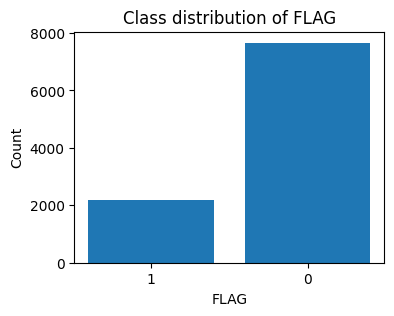

In [6]:
# Class imbalance
class_counts = df.groupBy("FLAG").count()
class_counts.show()

# Convert to pandas for plotting
pdf = class_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.bar(pdf["FLAG"].astype(str), pdf["count"])
plt.xlabel("FLAG")
plt.ylabel("Count")
plt.title("Class distribution of FLAG")
plt.show()


# Data cleaning and pre-processing

In [7]:
#Clean column names by removing spaces and special characters for Spark compatibility

def clean_column_name(col_name):
    return (
        col_name.strip()
                .replace(" ", "_")
                .replace("(", "")
                .replace(")", "")
                .replace(".", "_")
    )

for old_col in df.columns:
    df = df.withColumnRenamed(old_col, clean_column_name(old_col))

df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- Index: integer (nullable = true)
 |-- Address: string (nullable = true)
 |-- FLAG: integer (nullable = true)
 |-- Avg_min_between_sent_tnx: double (nullable = true)
 |-- Avg_min_between_received_tnx: double (nullable = true)
 |-- Time_Diff_between_first_and_last_Mins: double (nullable = true)
 |-- Sent_tnx: integer (nullable = true)
 |-- Received_Tnx: integer (nullable = true)
 |-- Number_of_Created_Contracts: integer (nullable = true)
 |-- Unique_Received_From_Addresses: integer (nullable = true)
 |-- Unique_Sent_To_Addresses: integer (nullable = true)
 |-- min_value_received: double (nullable = true)
 |-- max_value_received: double (nullable = true)
 |-- avg_val_received: double (nullable = true)
 |-- min_val_sent: double (nullable = true)
 |-- max_val_sent: double (nullable = true)
 |-- avg_val_sent: double (nullable = true)
 |-- min_value_sent_to_contract: double (nullable = true)
 |-- max_val_sent_to_contract: double (nullable = true)


In [8]:


df_clean = df.drop(
    "_c0",           # extra index column
    "Index",         # row index
    "Address",       # account identifier
    "ERC20_most_sent_token_type",
    "ERC20_most_rec_token_type"
)




The columns `ERC20_most_sent_token_type` and `ERC20_most_rec_token_type` contain
categorical string values. While these features may be useful in later modeling
stages, they are not required for the initial Big Data model.

Spark ML cannot directly handle raw string categories — they would need to be
encoded (e.g., StringIndexer + OneHotEncoder). To keep the first version of the
pipeline simple and computationally efficient, these columns were intentionally
excluded. This is a design choice for the baseline model and can be revisited
in later iterations if categorical token-type information becomes relevant.


TARGET VARIABLE AND MISSING VALUES

Ensure the target column is stored as an integer type for Spark ML compatibility.

In [9]:


df_clean = df_clean.withColumn("FLAG", col("FLAG").cast("integer"))

df_clean = df_clean.dropna()

print("Rows after cleaning:", df_clean.count())


Rows after cleaning: 9012


Initially we had 9841 rows.Again we will check imbalance.

In [10]:
df_clean.groupBy("FLAG").count().show()


+----+-----+
|FLAG|count|
+----+-----+
|   1| 1350|
|   0| 7662|
+----+-----+



FEATURE ASSEMBLY

Assemble all numeric feature columns into a single vector required for Spark ML modelling.VectorAssembler is a Spark ML transformer that takes many separate numeric columns and combines them into one single feature vector.

In [11]:


feature_cols = [c for c in df_clean.columns if c != "FLAG"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_features = assembler.transform(df_clean)


Train-test split-Split the dataset into training and testing subsets using an 80/20 ratio

In [12]:


train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

print("Training rows:", train_df.count())
print("Testing rows:", test_df.count())


Training rows: 7285
Testing rows: 1727


MODEL TRAINING

Train a Random Forest classifier using the assembled feature vector and the target label.

In [13]:
# Random Forest

rf = RandomForestClassifier(
    labelCol="FLAG",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_df)


MODEL EVALUATION

In [14]:


predictions = rf_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="FLAG",
    metricName="areaUnderROC",
)

auc = evaluator.evaluate(predictions)
print("AUC score:", auc)


AUC score: 0.9969439640709293


AUC preferred due to strong class imbalance.

Convert Spark predictions to Pandas and generate a classification report

In [15]:

pred_pd = predictions.select("FLAG", "prediction").toPandas()

print(classification_report(pred_pd["FLAG"], pred_pd["prediction"]))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1462
           1       0.97      0.88      0.92       265

    accuracy                           0.98      1727
   macro avg       0.98      0.94      0.95      1727
weighted avg       0.98      0.98      0.98      1727



The classification report shows excellent model performance, with high precision and recall for both classes, including strong detection of the minority fraud class.

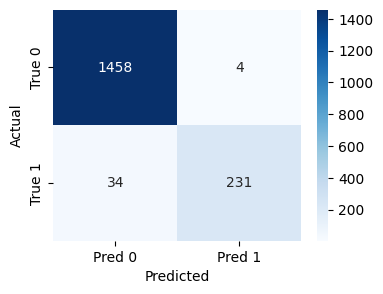

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Generate predictions using the trained Random Forest

In [26]:
predictions = rf_model.transform(test_df)


Extract fraud probabilities from the model output and save them to a CSV file

In [27]:
pred_pd = predictions.select("FLAG", "probability").toPandas()
pred_pd["fraud_prob"] = pred_pd["probability"].apply(lambda x: float(x[1]))
pred_pd = pred_pd[["FLAG", "fraud_prob"]]
pred_pd.to_csv("predictions_with_probs.csv", index=False)


Train a scikit-learn Random Forest on a sampled dataset and compute SHAP values to explain fraud predictions

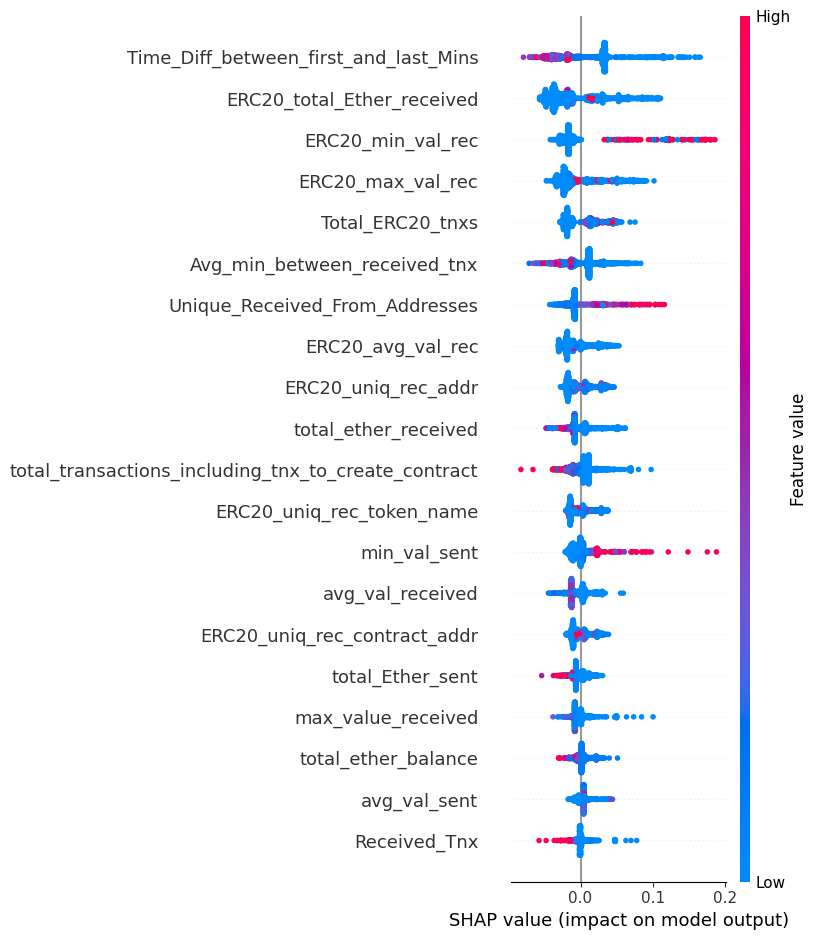

In [20]:


sample_pd = df_clean.sample(fraction=0.1, seed=42).toPandas()

X = sample_pd.drop(columns=["FLAG"])
y = sample_pd["FLAG"]

from sklearn.ensemble import RandomForestClassifier

rf_sklearn = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_sklearn.fit(X, y)

explainer = shap.TreeExplainer(rf_sklearn)


shap_values = explainer(X)

# Plot for fraud class (class = 1)
shap.summary_plot(
    shap_values.values[:, :, 1],
    X,
    feature_names=X.columns
)


The SHAP summary plot reveals that temporal and transactional features are most influential in fraud prediction. Long inactivity periods, low Ether received, and irregular transaction patterns significantly increase the likelihood of fraud. These insights support the model’s interpretability and align with known fraud behaviours in Ethereum networks